# CS5489 - Machine Learning
# Lecture 5a - Supervised Learning - Regression
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Linear Regression
2. Selecting Features
3. Removing Outliers
4. Non-linear regression

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

# Regression
- Supervised learning
  - Input observation $\mathbf{x}$, typically a vector in $\mathbb{R}^d$.
  - Output $y \in \mathbb{R}$, a real number.
- **Goal:** predict output $y$ from input $\mathbf{x}$.
  - i.e., learn the function $y = f(\mathbf{x})$.

In [2]:
linbias = 30
[linX, linY, lincoefs] = datasets.make_regression(n_samples=100, n_features=1, 
                                                  n_informative=1, bias=linbias, noise=10.0, 
                                                  coef=True, random_state=4487)
axbox = [-3, 3, -60, 100]
linfig = plt.figure()
plt.plot(linX, linY, 'b.')
plt.xlabel('feature x')
plt.ylabel('output y')
plt.grid(True); plt.axis(axbox)
plt.close()

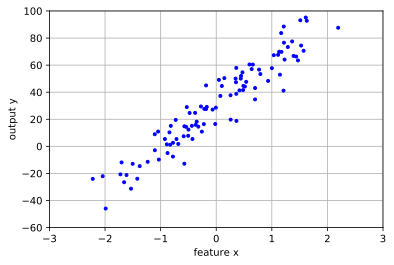

In [3]:
linfig

# Examples: 
- Predict Boston house price from number of rooms, or percentage of low-status households in neighborhood.

In [4]:
boston = datasets.load_boston()

bostonY = boston['target']
bostonX = boston['data'][:,[5,12]]

ss = 4   # subsample for illustration
bostonY = bostonY[::ss]
bostonX = bostonX[::ss]

boston1dfig = plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(bostonX[:,0], bostonY, 'b.')
plt.grid(True)
plt.ylabel('Home Price ($1000s)')
plt.xlabel('number of rooms')

plt.subplot(1,2,2)
plt.plot(bostonX[:,1], bostonY, 'b.')
plt.grid(True)
plt.ylabel('Home Price ($1000s)')
plt.xlabel('percent of low-status households')
plt.close()

boston2dfig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(bostonX[:,0], bostonX[:,1], c=bostonY, edgecolors='k', cmap='jet')
cbar = plt.colorbar()
cbar.set_label('Home Price ($1000s)')
plt.xlabel('number of rooms')
plt.ylabel('percent of low-status households')
plt.grid(True)
plt.close()

ax = boston2dfig.add_subplot(122, projection='3d')
ax.scatter(bostonX[:,0], bostonX[:,1], c=bostonY, edgecolors='k', cmap='jet')
ax.set_xlabel('number of rooms')
ax.set_ylabel('percent low-status households')
ax.set_zlabel('Home Price ($1000s)')



Text(0.5, 0, 'Home Price ($1000s)')

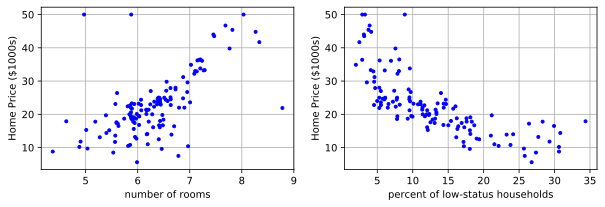

In [5]:
boston1dfig

- predict from both features

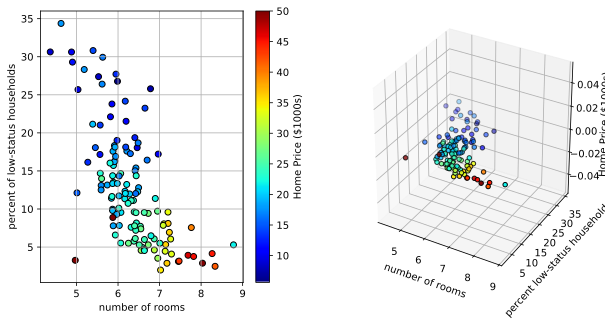

In [6]:
boston2dfig

# Linear Regression 
- **1-d case:** the output $y$ is a linear function of input feature $x$
  - $y = w * x + b $
  - $w$ is the slope, $b$ is the intercept.

In [7]:
linfig = plt.figure()
plt.plot(linX, linY, 'b.')
xr = linspace(axbox[0], axbox[1], 100)
plt.plot(xr, lincoefs*xr+linbias, 'r-', label='y = %0.4g x + %0.4g' % (lincoefs, linbias))
plt.xlabel('feature x')
plt.ylabel('output y')
plt.grid(True); plt.axis(axbox)
plt.legend(loc='lower right')
plt.close()

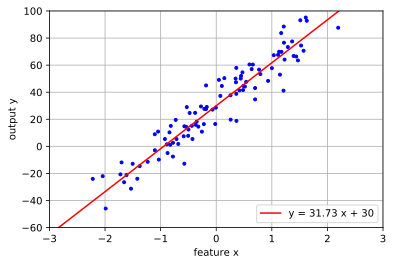

In [8]:
linfig

- **d-dim case**: the output $y$ is a linear combination of $d$ input variables $x_1, \cdots, x_d$:
  - $y = w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_d x_d$
- Equivalently, 
  - $y = w_0 + \mathbf{w}^T \mathbf{x} = w_0 +\sum_{j=1}^d w_j x_j$
    - $\mathbf{x}\in\mathbb{R}^d$ is the vector of input values.
    - $\mathbf{w}\in\mathbb{R}^d$ are the weights of the linear function, and $w_0$ is the intercept (bias term).

In [9]:

xr = [linspace(-3,3,100), linspace(-4,4,100)]
xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

w = array([1,2])
b = 20
yout = dot(allpts, w[:,newaxis]) + b
yout = yout.reshape(xgrid0.shape)

lin2dfig = plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(yout, origin='lower', extent=[-3,3,-4,4], cmap='Blues')
cbar.set_label('y')
cbar = plt.colorbar()
CS = plt.contour(xr[0], xr[1], yout, colors='k')
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.title('$y=x_1 + 2x_2 + 20$')
ax = lin2dfig.add_subplot(122, projection='3d')
ax.plot_surface(xgrid0, xgrid1, yout, cmap='Blues')
ax.contour(xr[0], xr[1], yout, zdir='z', offset=0, colors='k')
ax.set_zlim(0,35)
ax.set_zlabel('y')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.close()

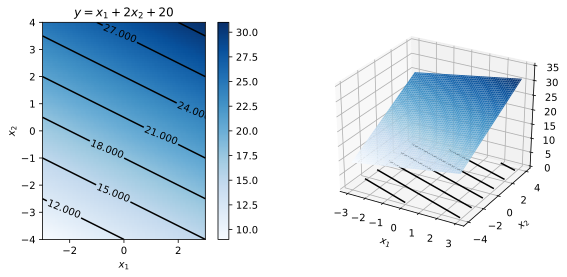

In [10]:
lin2dfig

# Ordinary Least Squares (OLS)
- The linear function has form $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b$.
- _How to estimate the parameters $(\mathbf{w},b)$ from the data?_
- Fit the parameters by minimizing the squared prediction error on the training set $\{(\mathbf{x}_i,y_i)\}_{i=1}^N$:
  $$\min_{\mathbf{w},b} \sum_{i=1}^N (y_i - f(\mathbf{x}_i))^2 = \min_{\mathbf{w},b} \sum_{i=1}^N (y_i - (\mathbf{w}^T\mathbf{x}_i + b))^2$$

- The bias term $b$ can be absorbed into $\mathbf{w}$ by redefining as follows:
  - $\mathbf{w} \leftarrow \begin{bmatrix}\mathbf{w}\\b\end{bmatrix}$, $\mathbf{x} \leftarrow \begin{bmatrix}\mathbf{x}\\1\end{bmatrix}$

- We can write the minimization problem as:
$$ \min_{\mathbf{w}} ||\mathbf{y}-\mathbf{X}^T\mathbf{w}||^2$$
  - where $\mathbf{X} = [\mathbf{x}_1 \cdots \mathbf{x}_N]$ is the data matrix,
  - and $\mathbf{y} = [y_1, \cdots, y_N]^T$ is vector of outputs.

- To obtain the solution:
  - 1) Expand the norm term:
$$\begin{aligned}||\mathbf{y}-\mathbf{X}^T\mathbf{w}||^2 &= (\mathbf{y}-\mathbf{X}^T\mathbf{w})^T(\mathbf{y}-\mathbf{X}^T\mathbf{w})\\
&= \mathbf{y}^T\mathbf{y} - 2 \mathbf{y}^T\mathbf{X}^T\mathbf{w} + \mathbf{w}^T\mathbf{X}\mathbf{X}^T\mathbf{w}
\end{aligned}$$
  - Find the minimum by taking the derivative and setting to 0:
$$\begin{aligned}\frac{d}{d\mathbf{w}} (\mathbf{y}^T\mathbf{y} - 2 \mathbf{y}^T\mathbf{X}^T\mathbf{w} + \mathbf{w}^T\mathbf{X}\mathbf{X}^T\mathbf{w})
&= -2\mathbf{X}\mathbf{y}  + 2\mathbf{X}\mathbf{X}^T\mathbf{w} = 0\\
&\Rightarrow \  \mathbf{X}\mathbf{X}^T\mathbf{w} = \mathbf{X}\mathbf{y} \\
&\Rightarrow \  \mathbf{w}^* = (\mathbf{X}\mathbf{X}^T)^{-1}\mathbf{X}\mathbf{y}
\end{aligned}$$
  - closed-form solution!
    - Note: $(\mathbf{X}\mathbf{X}^T)^{-1}\mathbf{X}$ is also called the _pseudo-inverse_ of $\mathbf{X}$.

# Examples: 1-d

In [11]:
def plot_linear_1d(model, axbox, X, Y):
    xr = linspace(axbox[0], axbox[1], 100).reshape(100,1)
    
    # prediction for range of x features
    ypred = model.predict(xr)

    plt.plot(X, Y, 'b.')
    plt.plot(xr, ypred, 'r-')
    plt.grid(True); plt.axis(axbox)

    # calculate mean-square error on training set
    MSE = metrics.mean_squared_error(Y, model.predict(X))
    
    plt.title("w={:.5f}; b={:.5f}\nMSE={:.5f}".format(float(model.coef_), float(model.intercept_), MSE))

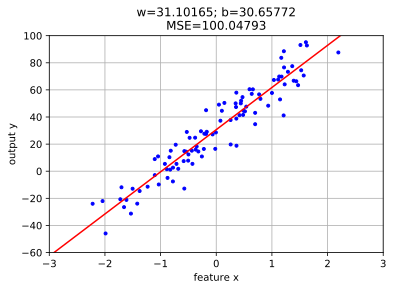

In [12]:
# fit using ordinary least squares
ols = linear_model.LinearRegression()
ols.fit(linX, linY)

# show plot
axbox = [-3, 3, -60, 100]
plt.figure()
plot_linear_1d(ols, axbox, linX, linY)
plt.xlabel('feature x'); plt.ylabel('output y');

# Boston housing price (1d)
- learn regression function for each feature separately

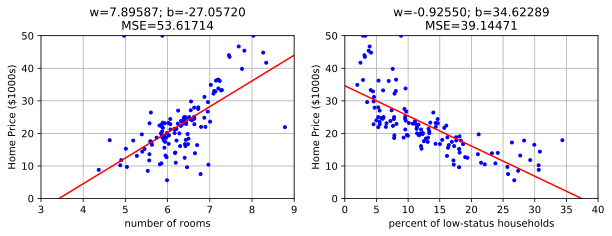

In [13]:
# fit each dimension of Boston data
plt.figure(figsize=(10,3))

bostonFeats = ('number of rooms', 'percent of low-status households')
bostonaxbox = ([3,9,0,50], [0,40,0,50])

for i in range(2):
    ols = linear_model.LinearRegression()
    tmpX = bostonX[:,i][:,newaxis]
    ols.fit(tmpX, bostonY)
    
    plt.subplot(1,2,i+1)
    plot_linear_1d(ols, bostonaxbox[i], tmpX, bostonY)
    plt.ylabel('Home Price ($1000s)'); plt.xlabel(bostonFeats[i])

...

- for both features together

In [14]:
def plot_linear_2d(model, axbox, X, Y):
    xr = [linspace(axbox[0],axbox[1],100), 
          linspace(axbox[2],axbox[3],100)]
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

    ypred = model.predict(allpts).reshape(xgrid0.shape)

    # calculate MSE
    MSE = metrics.mean_squared_error(Y, model.predict(X))

    # make figure
    vmin = Y.min()-10
    vmax = Y.max()+10
    
    # show the 2d function as an image
    plt.imshow(ypred, origin='lower', extent=axbox, aspect='auto', vmin=vmin, vmax=vmax, cmap='jet')
    plt.scatter(X[:,0], X[:,1], c=Y, vmin=vmin, vmax=vmax, edgecolors='k', cmap='jet')
    plt.grid(True); plt.axis(axbox)
    plt.title('w=[{:.5f},{:.5f}]; b={:.5f}\nMSE={:.5f}'.format
              (model.coef_[0], model.coef_[1], model.intercept_, MSE))

In [15]:
bostonaxbox2 = bostonaxbox[0][0:2] + bostonaxbox[1][0:2]

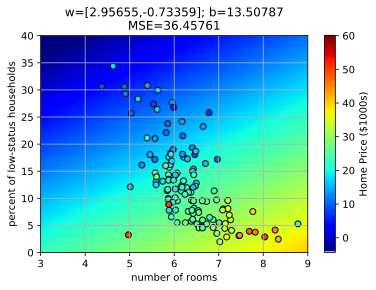

In [16]:
# learn with both dimensions
ols = linear_model.LinearRegression()
ols.fit(bostonX, bostonY)

# make figure
plt.figure()
plot_linear_2d(ols, bostonaxbox2, bostonX, bostonY)
cbar = plt.colorbar()
cbar.set_label('Home Price ($1000s)')
plt.xlabel('number of rooms')
plt.ylabel('percent of low-status households');

...

- interpretation from the linear model parameters:
  - each room increases home price by $\$$2956 ($w_1$)
  - each percentage of low-status households decreases home price by $\$$733 ($w_2$)
  - the "starting" price is $\$$13,508 ($b$).

...

# Selecting Features
- The Boston housing data actually has 12 features.
  - plots of feature vs. housing price

In [17]:
fs = [0,1,2,3,4,5,6,7,8,9,10,12]
bostonY = boston['target'][::ss]
bostonX = boston['data'][::ss,fs]


bostonAttr = [
        ['CRIM',     'per capita crime rate by town'],
        ['ZN',       'proportion of residential land zoned for lots over 25,000 sq.ft.'], 
        ['INDUS',    'proportion of non-retail business acres per town'], 
        ['CHAS',     'Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)'], 
        ['NOX',      'nitric oxides concentration (parts per 10 million)'], 
        ['RM',       'average number of rooms per dwelling'], 
        ['AGE',      'proportion of owner-occupied units built prior to 1940'], 
        ['DIS',      'weighted distances to five Boston employment centres'], 
        ['RAD',      'index of accessibility to radial highways'], 
        ['TAX',      'full-value property-tax rate per $10,000'], 
        ['PTRATIO',  'pupil-teacher ratio by town'], 
#        ['B',        '1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town'],
        ['LSTAT',    '% lower status of the population']
    ]

bostonffig = plt.figure(figsize=(10,5))
for i in range(bostonX.shape[1]):
    plt.subplot(3,5,i+1)
    plt.plot(bostonX[:,i], bostonY, 'b.')
    plt.grid(True)
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.title(bostonAttr[i][0])
plt.close()


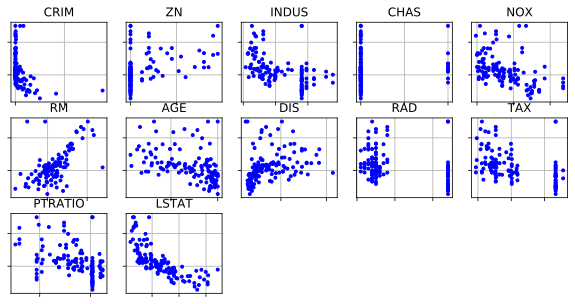

In [18]:
bostonffig

<pre>
     CRIM = per capita crime rate by town`
       ZN = proportion of residential land zoned for lots over 25,000 sq.ft.`
    INDUS = proportion of non-retail business acres per town
     CHAS = Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
      NOX = nitric oxides concentration (parts per 10 million)
       RM = average number of rooms per dwelling
      AGE = proportion of owner-occupied units built prior to 1940
      DIS = weighted distances to five Boston employment centres
      RAD = index of accessibility to radial highways
      TAX = full-value property-tax rate per $10,000
  PTRATIO = pupil-teacher ratio by town
    LSTAT = % lower status of the population
</pre>

- Use `pandas` to view pairwise relationships
  - diagonal shows the histogram
  - off-diagonal shows plots for two features at a time 

In [19]:
import pandas as pd
boston_feature_names = [x[0] for x in bostonAttr]
boston_df = pd.DataFrame(bostonX, columns=boston_feature_names)

tmp=pd.plotting.scatter_matrix(boston_df, c=bostonY, figsize=(9, 9),
                              marker='o', hist_kwds={'bins': 20}, s=10,
                              alpha=.5)

- _Can we select a few features that are good for predicting the price?_
  - This will provide some insight about our data and what is important.

# Shrinkage
- Add a _regularization_ term to "shrink" some linear weights to zero.
  - features associated with zero weight are not important since they aren't used to calculate the function output.
  - $y = w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_d x_d$

# Ridge Regression
- Add regularization term to OLS:
$$\min_{\mathbf{w},b} \alpha ||\mathbf{w}||^2 + \sum_{i=1}^N (y_i - f(\mathbf{x}_i))^2 $$
- the first term is the _regularization term_
  - $||\mathbf{w}||^2 = \sum_{j=1}^d w_j^2$ penalizes large weights (aka L2-norm)
  - $\alpha$ is the hyperparameter that controls the amount of shrinkage
    - larger $\alpha$ means more shrinkage.
    - $\alpha=0$ is the same as OLS.
- the second term is the _data-fit term_
  - sum-squared error of the prediction, same as linear regression.

- Also has a closed-form solution (similar derivation to linear regression):
  - $\mathbf{w}^* = (\mathbf{X}\mathbf{X}^T + \alpha I)^{-1}\mathbf{X}\mathbf{y}$
  - Similar to the solution for linear regression: $\mathbf{w}^* = (\mathbf{X}\mathbf{X}^T)^{-1}\mathbf{X}\mathbf{y}$
- What is the effect of the scaled identity matrix $\alpha I$?

- with linear regression, if $\mathbf{X}$ does not span the input space $\mathbb{R}^d$, then $\mathbf{X}\mathbf{X}^T$ could be ill-conditioned or non-invertible.
  - i.e., we don't know how the data varies in the space orthogonal to $\mathbf{X}$.
- with ridge regression, the scaled identity conditions the matrix $\mathbf{X}\mathbf{X}^T$ so that the inverse can be computed.
  - (The term "ridge regression" comes from the closed-form solution, where a "ridge" is added to the diagonal of the covariance matrix)

# Example on Boston data


In [20]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(bostonX, bostonY, 
  train_size=0.8, test_size=0.2, random_state=4487)

# normalize feature values to zero mean and unit variance
# this makes comparing weights more meaningful
#   feature value 0 means the average value for that features
#   feature value of +1 means one standard deviation above average
#   feature value of -1 means one standard deviation below average
scaler = preprocessing.StandardScaler()  
trainXn = scaler.fit_transform(trainX)  
testXn  = scaler.transform(testX)
    
print(trainXn.shape)
print(testXn.shape)

(101, 12)
(26, 12)


- vary $\alpha$ from $10^{-3}$ (little shrinkage) to $10^6$ (lots of shrinkage)

In [21]:
# alpha values to try
alphas = logspace(-3,6,50)

MSEs = empty(len(alphas))
ws   = empty((len(alphas), trainXn.shape[1]))
for i,alpha in enumerate(alphas):
    # learn the RR model
    rr = linear_model.Ridge(alpha=alpha)
    rr.fit(trainXn, trainY)
    ws[i,:] = rr.coef_   # save weights
    
    MSEs[i] = metrics.mean_squared_error(testY, rr.predict(testXn))

- Effect...
  - for small $\alpha$, all weights are non-zero.
  - for large $\alpha$, all weights shrink to 0.
  - somewhere in between is the best model...

In [22]:
rfig = plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.semilogx(alphas, ws)
plt.xlabel('$\\alpha$'); plt.ylabel('weight $w_j$')
plt.grid(True); plt.title("Ridge Regression")
plt.subplot(1,2,2)
plt.semilogx(alphas, MSEs)
plt.xlabel('$\\alpha$'); plt.ylabel('test MSE')
plt.axis([alphas[0], alphas[-1], 40, 100])
plt.grid(True); plt.title('MSE vs $\\alpha$');
plt.close()

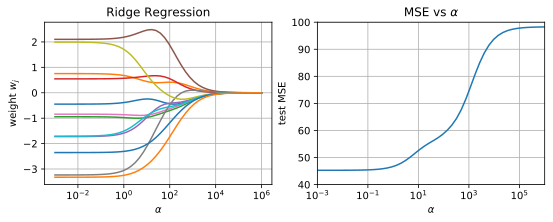

In [23]:
rfig

# Selecting $\alpha$ using cross-validation
- built-in cross-validation (RidgeCV)

In [24]:
# train RR with cross-validation
rr = linear_model.RidgeCV(alphas=alphas, cv=5)
rr.fit(trainXn, trainY)

MSE = metrics.mean_squared_error(testY, rr.predict(testXn))
print("MSE =", MSE)
print("alpha =", rr.alpha_)
print("w =", rr.coef_)

MSE = 55.24072984514399
alpha = 25.595479226995383
w = [-0.29070744  0.39475303 -0.87840328  0.67118967 -0.62982053  2.44838106
 -0.80391822 -1.41878524  0.27755795 -0.69521816 -1.75392601 -2.48098356]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Interpretation
- Which weights are most important?
  - negative weights indicate factors that decrease the house price
    - *Examples:* LSTAT (having higher percentage of lower status population), DIS (distance to business areas), PTRATIO (higher student-teacher ratio)
  - positive weights indicate factors that increase the house price
    - *Examples:* RM (having more rooms), RAD (proximity to highways)

In [25]:
# print out sorted coefficients with descriptions
def print_coefs(coefs, bostonAttr):
    # sort coefficients from smallest to largest, then reverse it
    inds = argsort(abs(coefs))[::-1]
    # print out
    print("weight : feature description")
    for i in inds:
        print("{: .3f} : {:7s} {}".format(coefs[i], bostonAttr[i][0], bostonAttr[i][1]))

print_coefs(rr.coef_, bostonAttr)

weight : feature description
-2.481 : LSTAT   % lower status of the population
 2.448 : RM      average number of rooms per dwelling
-1.754 : PTRATIO pupil-teacher ratio by town
-1.419 : DIS     weighted distances to five Boston employment centres
-0.878 : INDUS   proportion of non-retail business acres per town
-0.804 : AGE     proportion of owner-occupied units built prior to 1940
-0.695 : TAX     full-value property-tax rate per $10,000
 0.671 : CHAS    Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
-0.630 : NOX     nitric oxides concentration (parts per 10 million)
 0.395 : ZN      proportion of residential land zoned for lots over 25,000 sq.ft.
-0.291 : CRIM    per capita crime rate by town
 0.278 : RAD     index of accessibility to radial highways


# Better shrinkage
- With ridge regression, some weights are small but still non-zero.
  - these are less important, but somehow still necessary.
- To get better shrinkage to zero, we can change the regularization term to encourage more weights to be 0. 
  - also called "sparse" weights, or encouraging "sparsity".

# LASSO
- LASSO = "Least absolute shrinkage and selection operator"
- keep the same data fit term, but change the regularization term:
  - sum of absolute weight values: $\sum_{j=1}^d|w_j|$
    - also called L1-norm: $||\mathbf{w}||_1$
  - when a weight is close to 0, the regularization term can move the weight to be equal to 0.
$$\min_{\mathbf{w},b} \alpha \sum_{j=1}^d|w_j| + \sum_{i=1}^N (y_i - f(\mathbf{x}_i))^2 $$


# Comparison of L2 and L1 norms.
- L2 focuses more on large weights.
- L1 treats all weights equally.

In [26]:
x = linspace(-3,3,100)
normfig = plt.figure()
plt.plot(x,x**2, 'r-', label='L2-norm')
plt.plot(x,abs(x), 'b-', label='L1-norm')
plt.xlabel('w')
plt.ylabel('norm')
plt.grid(True)
plt.legend()
plt.annotate(s="focus more on\nlarge weights", 
             xy=(-2.5,6.25), xytext=(-1.8,7.5), backgroundcolor='white', 
            arrowprops=dict(arrowstyle="->"))

plt.annotate(s="focus less on\nsmall weights", 
             xy=(0.5,.25), xytext=(1.5,.25), backgroundcolor='white',
            arrowprops=dict(arrowstyle="->"))

plt.annotate(s="", 
             xy=(-.5,.5), xytext=(-0.5,4.5), backgroundcolor='white',
            arrowprops=dict(arrowstyle="->"))
plt.annotate(s="focus equally on small\nand large weights.\nallows small weights\nto go to 0.", 
             xy=(-2,2), xytext=(-1,4.5), backgroundcolor='white',
            arrowprops=dict(arrowstyle="->"))


plt.close()

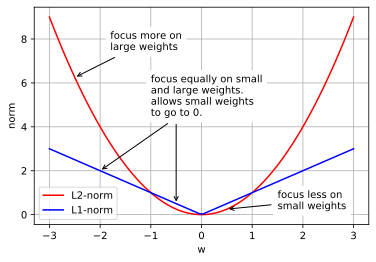

In [27]:
normfig

# Comparison of L2 and L1 norms
- During optimization with L1 norm:
  - for a given value of L1 norm, the minimal objective is usually in a "corner" of the L1 norm contour.
  - The "corner" has some weights that are 0.
  
<center>
<table>
<tr><td>L1</td><td>L2</td></tr>
<tr><td>
<img src="imgs/l1.png" width=400>
</td><td>
<img src="imgs/l2.png" width=400>
</td></tr></table>
</center>

In [28]:
lasalphas = logspace(-3,2,50)

lassoMSEs  = empty(len(alphas))
lassows   = empty((len(alphas), trainXn.shape[1]))
for i,alpha in enumerate(lasalphas):
    # learn the LASSO model
    las = linear_model.Lasso(alpha=alpha)
    las.fit(trainXn, trainY)
    lassows[i,:] = las.coef_   # save weights
    
    lassoMSEs[i] = metrics.mean_squared_error(testY, las.predict(testXn))

In [29]:
lfig = plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.semilogx(lasalphas, lassows)
plt.xlabel('$\\alpha$'); plt.ylabel('weight $w_j$')
plt.grid(True)
plt.title('LASSO')
plt.subplot(1,2,2)
plt.semilogx(lasalphas, lassoMSEs)
plt.xlabel('$\\alpha$'); plt.ylabel('test MSE')
plt.axis([lasalphas[0], lasalphas[-1], 14, 100])
plt.grid(True)
plt.close()

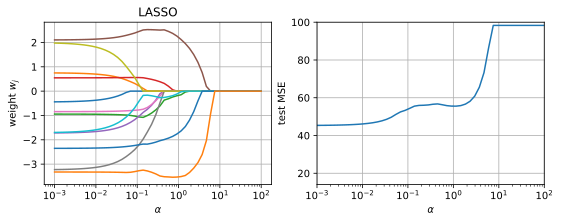

In [30]:
lfig

# Feature selection
- Select $\alpha$ to obtain a given number of features

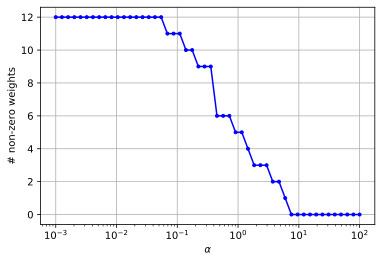

In [31]:
# count the number of non-zero weights
nzweights = sum(abs(lassows)>1e-6, axis=1)

plt.semilogx(lasalphas, nzweights, 'b.-')
plt.grid(True)
plt.xlabel('$\\alpha$'); plt.ylabel('# non-zero weights');

In [32]:
# get alpha where non-zero weights = 5
myi = where(nzweights==5)[0][0]
print("alpha=", lasalphas[myi])
print("MSE =", lassoMSEs[myi])
print("w =", lassows[myi,:])

alpha= 0.9102981779915218
MSE = 55.579375077684396
w = [-0.          0.         -0.19049149  0.         -0.          2.26455808
 -0.         -0.         -0.         -0.11944939 -1.76235357 -3.53224554]


## Interpretation
- weights for unimportant features are set to 0
  - RAD, DIS, AGE, ...
- important features have non-zero weights
  - LSTAT, RM, PTRATIO, INDUS, TAX

In [33]:
print_coefs(lassows[myi,:], bostonAttr)

weight : feature description
-3.532 : LSTAT   % lower status of the population
 2.265 : RM      average number of rooms per dwelling
-1.762 : PTRATIO pupil-teacher ratio by town
-0.190 : INDUS   proportion of non-retail business acres per town
-0.119 : TAX     full-value property-tax rate per $10,000
-0.000 : RAD     index of accessibility to radial highways
-0.000 : DIS     weighted distances to five Boston employment centres
-0.000 : AGE     proportion of owner-occupied units built prior to 1940
-0.000 : NOX     nitric oxides concentration (parts per 10 million)
 0.000 : CHAS    Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 0.000 : ZN      proportion of residential land zoned for lots over 25,000 sq.ft.
-0.000 : CRIM    per capita crime rate by town


# Cross-validation to select $\alpha$
- Use built-in CV function
  - selects $\alpha$ with lowest error.

In [34]:
# fit with cross-validation (alpha range is determined automatically)
las = linear_model.LassoCV()
las.fit(trainXn, trainY)

MSE = metrics.mean_squared_error(testY, las.predict(testXn))
print("MSE =", MSE)
print("alpha =", las.alpha_)
print("w =", las.coef_)

MSE = 56.60821855842052
alpha = 0.42282299918181265
w = [-0.          0.         -0.44153488  0.33751247 -0.          2.50717888
 -0.         -0.08340191 -0.         -0.26028207 -2.00520967 -3.54333686]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


## Interpretation
- RAD, AGE, NOX, ZN, CRIM are unimportant features.

In [35]:
print_coefs(las.coef_, bostonAttr)

weight : feature description
-3.543 : LSTAT   % lower status of the population
 2.507 : RM      average number of rooms per dwelling
-2.005 : PTRATIO pupil-teacher ratio by town
-0.442 : INDUS   proportion of non-retail business acres per town
 0.338 : CHAS    Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
-0.260 : TAX     full-value property-tax rate per $10,000
-0.083 : DIS     weighted distances to five Boston employment centres
-0.000 : RAD     index of accessibility to radial highways
-0.000 : AGE     proportion of owner-occupied units built prior to 1940
-0.000 : NOX     nitric oxides concentration (parts per 10 million)
 0.000 : ZN      proportion of residential land zoned for lots over 25,000 sq.ft.
-0.000 : CRIM    per capita crime rate by town


# Sparsity Constraints

- In previous formulations, LASSO and Ridge Regression only encourage sparisty using a regularizer.
- We can also formulate the regression problem with *explicit* sparsity constraints:
$$ min_{\mathbf{w},b} \sum_{i=1}^N (y_i - f(\mathbf{x}_i))^2, \mathrm{s.t.}\ ||\mathbf{w}||_0 \leq K $$
  - L0-norm: $||\mathbf{w}||_0$ = the number of non-zero entries in $\mathbf{w}$.
    - (not really a norm)
  - $K$ is a hyperparameter - how many non-zero coefficients are desired.

# Serious problem...
- LASSO and Ridge Regression are convex problems
  - Ridge Regression - closed-form solution
  - LASSO - efficient optimization algorithms to get exact solution
- Optimization problems with L0-norm constraints are NP-hard.
  - Combinatorial problem - all combinations of features need to be tried.

# Orthogonal Matching Pursuit (OMP)

- **Idea:** greedy algorithm that iteratively selects the feature that is most correlated with the current residual error.
- Algorithm
  - Initialize the residual: $\mathbf{r} = \mathbf{y}$
  - For $t$ in 1 to $K$
    - Find the most correlated feature: $j = \mathop{\mathrm{argmax}}_j | \mathbf{r}^T \mathbf{x}_j |$, where $\mathbf{x}_j$ is the j-th row of $\mathbf{X}$ (the j-th features).
    - Compute the weight: $w_j = \mathop{\mathrm{argmin}}_{w_j} ||\mathbf{r} - \mathbf{x}_j w_j||^2$
    - Update the residual: $\mathbf{r} -= \mathbf{x}_j w_j$

In [36]:
# Example
omp = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=2)
omp.fit(trainXn, trainY)

MSE = metrics.mean_squared_error(testY, omp.predict(testXn))
print("MSE =", MSE)
print(omp.coef_)
print(omp.intercept_)

MSE = 53.86974967354984
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -2.62819004 -5.96007042]
22.85940594059405


In [37]:
print_coefs(omp.coef_, bostonAttr)

weight : feature description
-5.960 : LSTAT   % lower status of the population
-2.628 : PTRATIO pupil-teacher ratio by town
 0.000 : TAX     full-value property-tax rate per $10,000
 0.000 : RAD     index of accessibility to radial highways
 0.000 : DIS     weighted distances to five Boston employment centres
 0.000 : AGE     proportion of owner-occupied units built prior to 1940
 0.000 : RM      average number of rooms per dwelling
 0.000 : NOX     nitric oxides concentration (parts per 10 million)
 0.000 : CHAS    Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 0.000 : INDUS   proportion of non-retail business acres per town
 0.000 : ZN      proportion of residential land zoned for lots over 25,000 sq.ft.
 0.000 : CRIM    per capita crime rate by town


- Note that LASSO selects different features, and also has worse MSE.

In [38]:
# get alpha where non-zero weights = 2
myi = where(nzweights==2)[0][0]
print("MSE =", lassoMSEs[myi])
print_coefs(lassows[myi,:], bostonAttr)

MSE = 65.57831140414783
weight : feature description
-2.605 : LSTAT   % lower status of the population
 0.765 : RM      average number of rooms per dwelling
-0.000 : PTRATIO pupil-teacher ratio by town
-0.000 : TAX     full-value property-tax rate per $10,000
-0.000 : RAD     index of accessibility to radial highways
 0.000 : DIS     weighted distances to five Boston employment centres
-0.000 : AGE     proportion of owner-occupied units built prior to 1940
-0.000 : NOX     nitric oxides concentration (parts per 10 million)
 0.000 : CHAS    Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
-0.000 : INDUS   proportion of non-retail business acres per town
 0.000 : ZN      proportion of residential land zoned for lots over 25,000 sq.ft.
-0.000 : CRIM    per capita crime rate by town
